In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zarr
import nrrd

### Load data

In [3]:
ts_naive = np.load('/groups/bishop/bishoplab/Luuk/data/RIVERFISH/MF50/cell_dff_avgfirst/cell_mean/cell_mean_visrap.npy')
ts_NMF = zarr.load('/groups/bishop/bishoplab/Luuk/segmentNMF/segmentNMF/temporal_components_sl.zarr')

# ts_naive = np.concatenate((np.full_like(ts_naive[0], fill_value=np.nan)[None, :], ts_naive))

In [4]:
ts_naive = ts_naive/np.max(ts_naive, axis=1)[:, None]
ts_NMF = ts_NMF/np.max(ts_NMF, axis=1)[:, None]

/tmp/ipykernel_100069/92560035.py:1: RuntimeWarning: invalid value encountered in divide
  ts_naive = ts_naive/np.max(ts_naive, axis=1)[:, None]


In [5]:
valid_inds_naive = np.where(~np.isnan(ts_naive[:, 0]))[0]
valid_inds_NMF = np.where(~np.isnan(ts_NMF[:, 0]))[0]

valid_inds = np.intersect1d(valid_inds_naive+1, valid_inds_NMF)
# valid_inds_naive = valid_inds_naive[np.where([valid_inds_naive == v for v in valid_inds])[0]]
# valid_inds_NMF = valid_inds_NMF[np.where([valid_inds_NMF == v for v in valid_inds])[0]]
# valid_inds.shape

In [6]:
# # Select only valid neuron indices
# N_cells = ts_NMF.shape[0]
# valid_inds = np.where(np.logical_and(~np.isnan(ts_NMF[:N_cells, 0]), ~np.isnan(ts_naive[:N_cells, 0])))[0]

N_neurons = len(valid_inds)
print(N_neurons)

ts_naive = ts_naive[valid_inds]
ts_NMF = ts_NMF[valid_inds]

15251


In [7]:
print(ts_naive.shape, ts_NMF.shape)

(15251, 2752) (15251, 2752)


In [8]:
# Load raw data
segments_path = '/groups/bishop/bishoplab/Luuk/segmentNMF/notebooks/NMF_development/masks_sl.zarr'
timeseries_path = '/groups/bishop/bishoplab/Luuk/segmentNMF/notebooks/NMF_development/ts_data_sl.zarr'

segments = zarr.load(segments_path)
ts = zarr.load(timeseries_path)

# Correlations

### Correlation NMF to naive

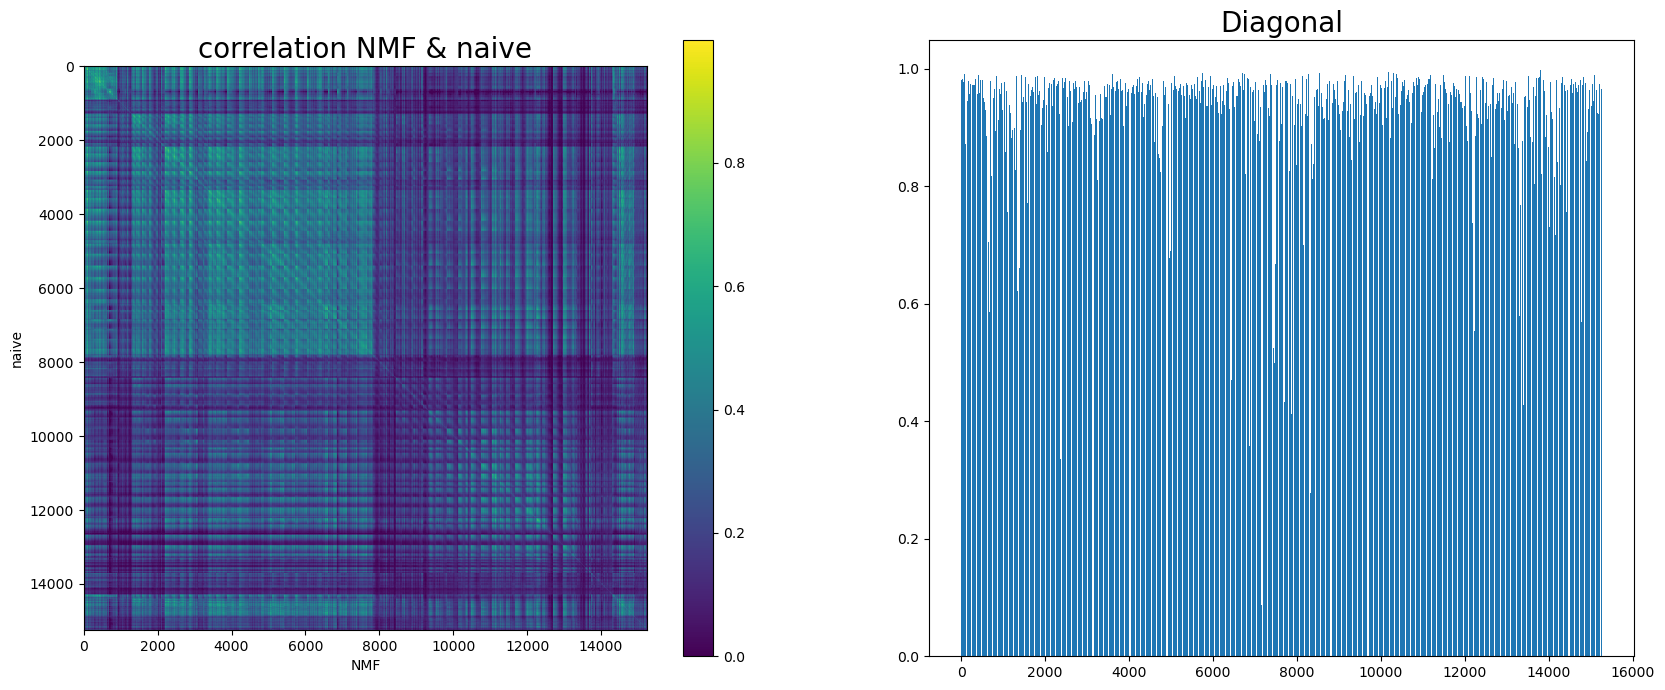

In [9]:
fig = plt.figure(figsize=(20, 8))

ax = plt.subplot(121)
corrmat = np.corrcoef(ts_naive, ts_NMF)[:N_neurons][:, N_neurons:]
# np.fill_diagonal(corrmat, 0)
im = ax.imshow(corrmat, vmin=0, vmax=None)
fig.colorbar(im, ax=ax)
ax.set_title('correlation NMF & naive', fontsize=20)
ax.set_xlabel('NMF')
ax.set_ylabel('naive')

ax = plt.subplot(122)
im = ax.bar(np.arange(corrmat.shape[0]), np.diag(corrmat))
ax.set_title('Diagonal', fontsize=20)

plt.show()

### Neuron-neuron correlations

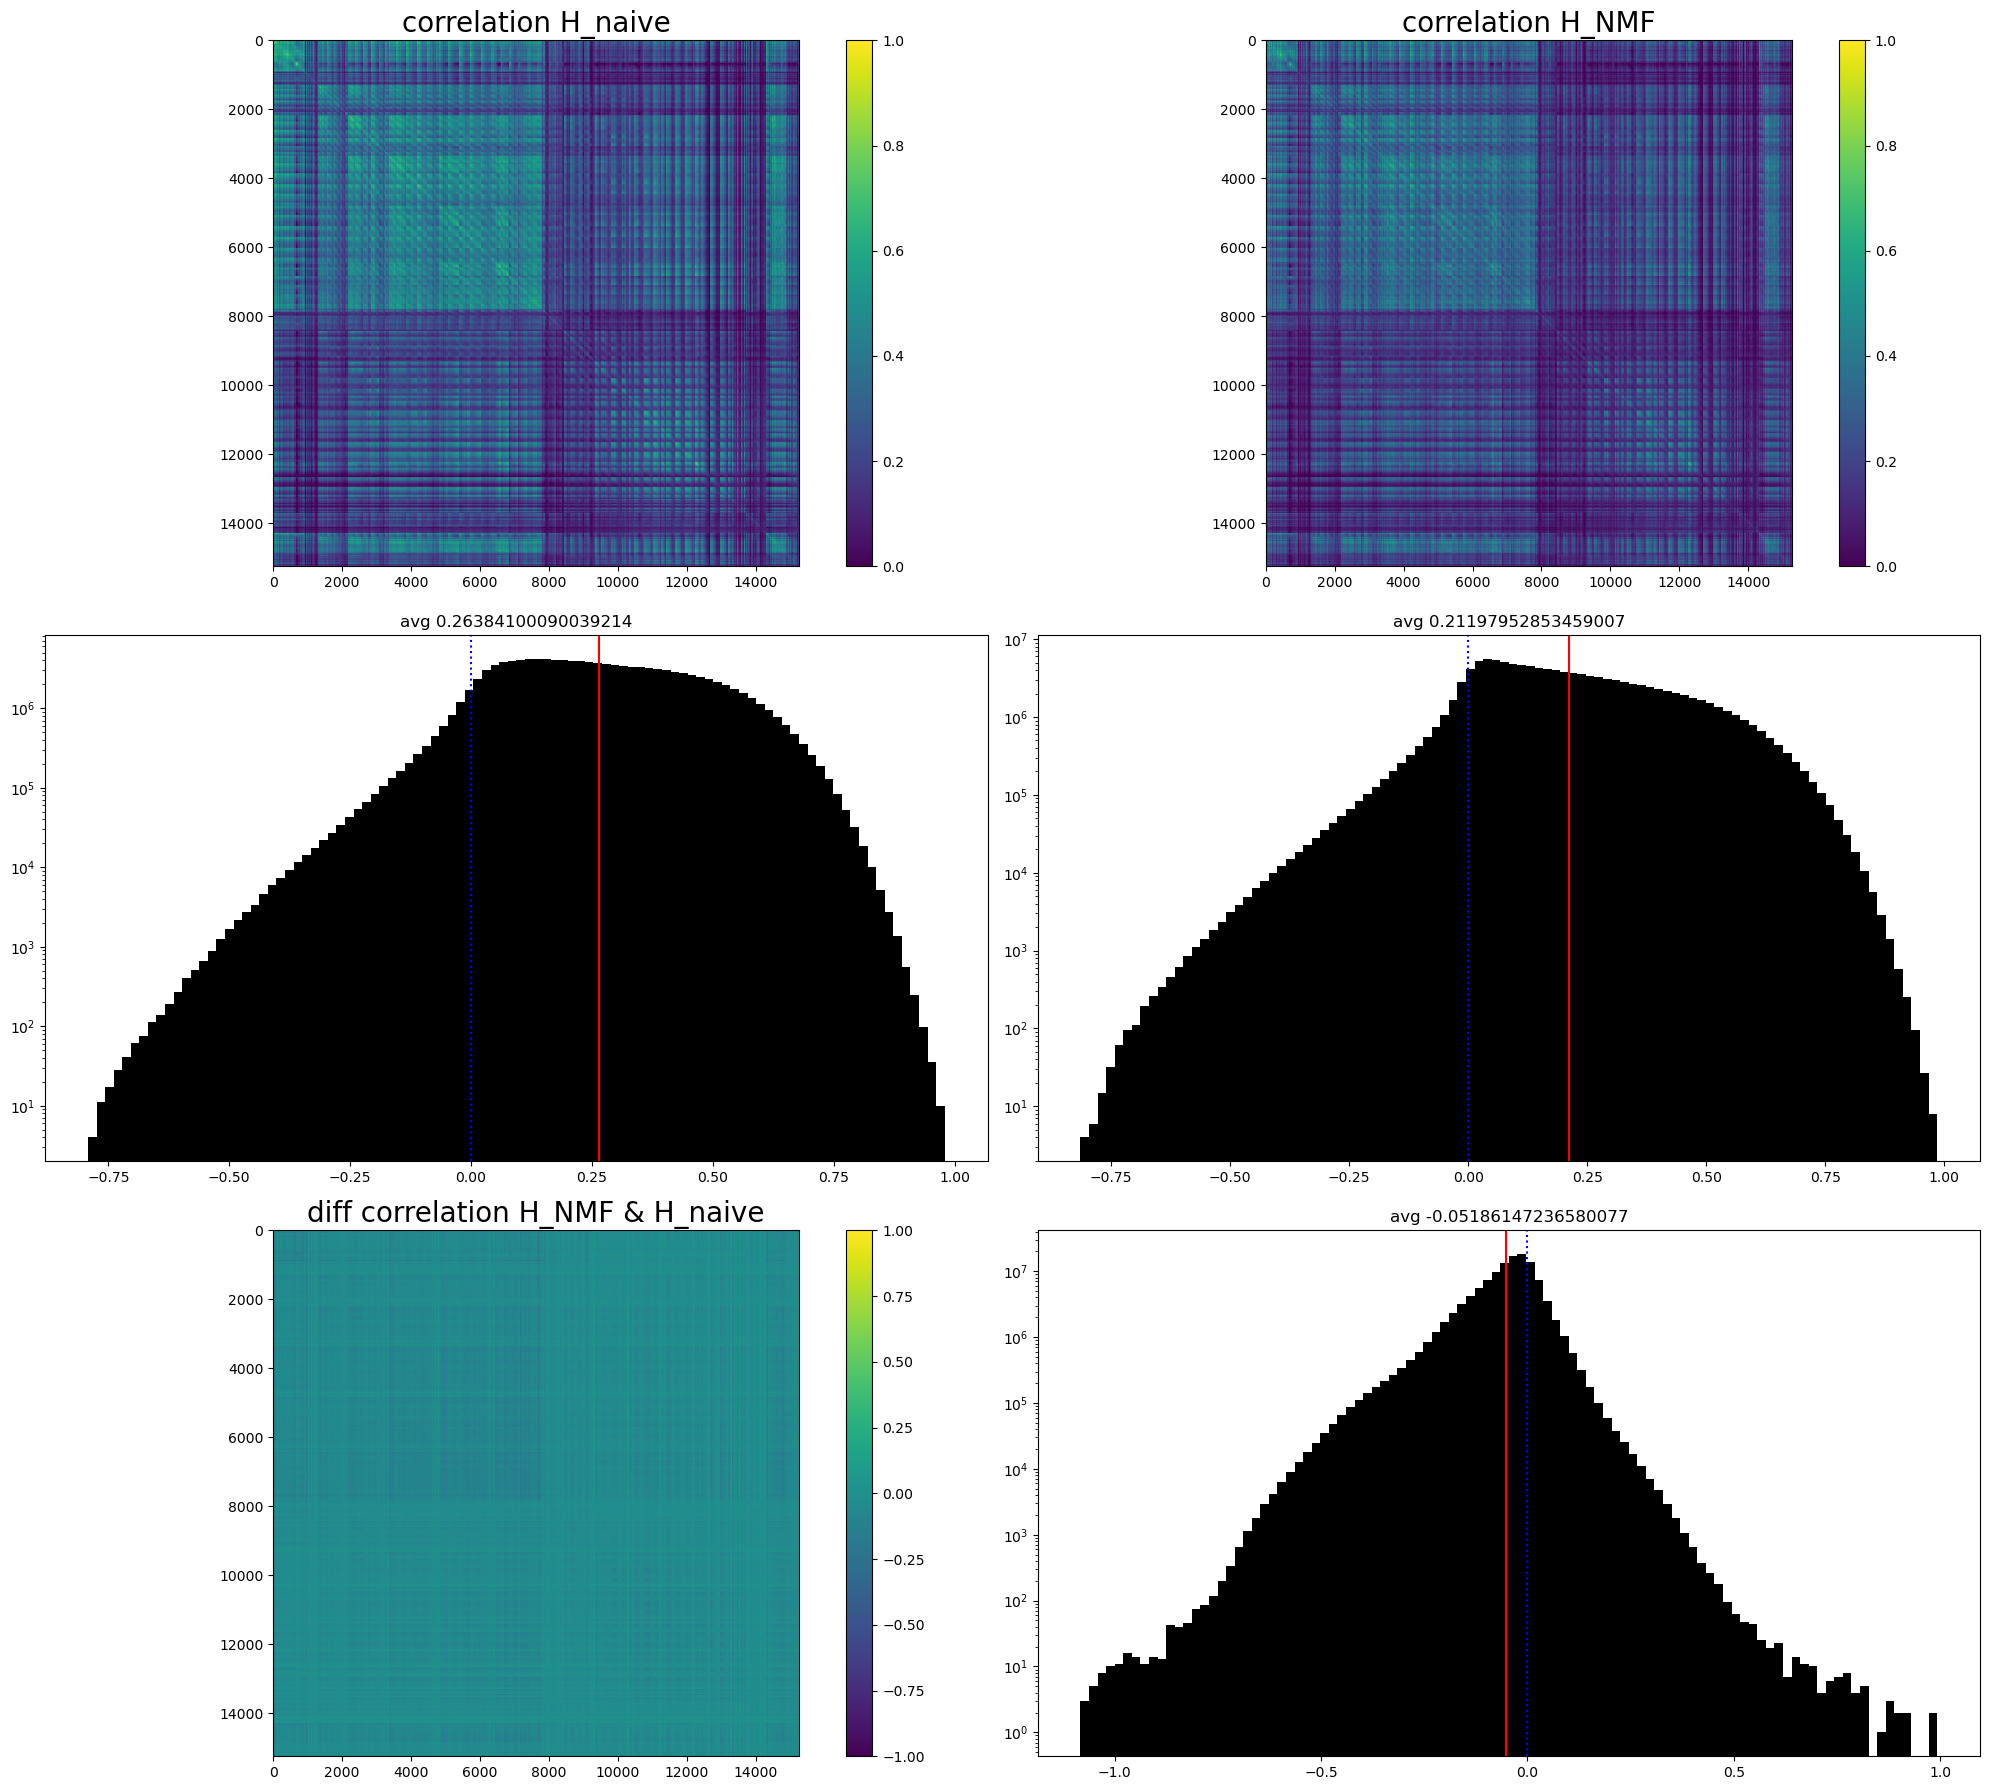

In [10]:
fig = plt.figure(figsize=(20, 18))

ax = plt.subplot(321)
corrmat_naive = np.corrcoef(ts_naive)
im = ax.imshow(corrmat_naive, vmin=0, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('correlation H_naive', fontsize=20)

ax = plt.subplot(322)
corrmat_NMF = np.corrcoef(ts_NMF)
im = ax.imshow(corrmat_NMF, vmin=0, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('correlation H_NMF', fontsize=20)

ax = plt.subplot(323)
triu_indices = np.triu_indices(N_neurons, k=1)
ax.hist(corrmat_naive[triu_indices], bins=100, color='k')
ax.set_yscale('log')
ax.axvline(np.nanmean(corrmat_naive), color='r')
ax.axvline(0, color='b', linestyle=':')
ax.set_title('avg {}'.format(np.nanmean(corrmat_naive)))

ax = plt.subplot(324)
triu_indices = np.triu_indices(N_neurons, k=1)
ax.hist(corrmat_NMF[triu_indices], bins=100, color='k')
ax.set_yscale('log')
ax.axvline(np.nanmean(corrmat_NMF), color='r')
ax.axvline(0, color='b', linestyle=':')
ax.set_title('avg {}'.format(np.nanmean(corrmat_NMF)))

ax = plt.subplot(325)
diff_corrmat = corrmat_NMF - corrmat_naive
im = ax.imshow(diff_corrmat, vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('diff correlation H_NMF & H_naive', fontsize=20)

ax = plt.subplot(326)
triu_indices = np.triu_indices(N_neurons, k=1)
ax.hist(diff_corrmat[triu_indices], bins=100, color='k')
ax.set_yscale('log')
ax.axvline(np.nanmean(diff_corrmat), color='r')
ax.axvline(0, color='b', linestyle=':')
ax.set_title('avg {}'.format(np.nanmean(diff_corrmat)))

fig.tight_layout()
plt.show()

### Spatially plot NMF-Naive neuron-neuron correlation

In [11]:
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

correlations = np.array([pearsonr(naive, NMF).statistic for naive, NMF in tqdm(zip(ts_naive, ts_NMF))])

0it [00:00, ?it/s]

In [12]:
corr_seg_vol = np.full_like(segments, dtype='float32', fill_value=np.nan)
mn_act_seg_vol = np.full_like(segments, dtype='float32', fill_value=np.nan)

unique_segments = np.unique(segments)[1:]
ts_mean = np.mean(ts, axis=0)

for i, u in tqdm(enumerate(valid_inds)):
    inds = np.nonzero(segments == u + 1)
    corr_seg_vol[inds] = correlations[i]
    mn_act_seg_vol[inds] = ts_mean[inds]

0it [00:00, ?it/s]

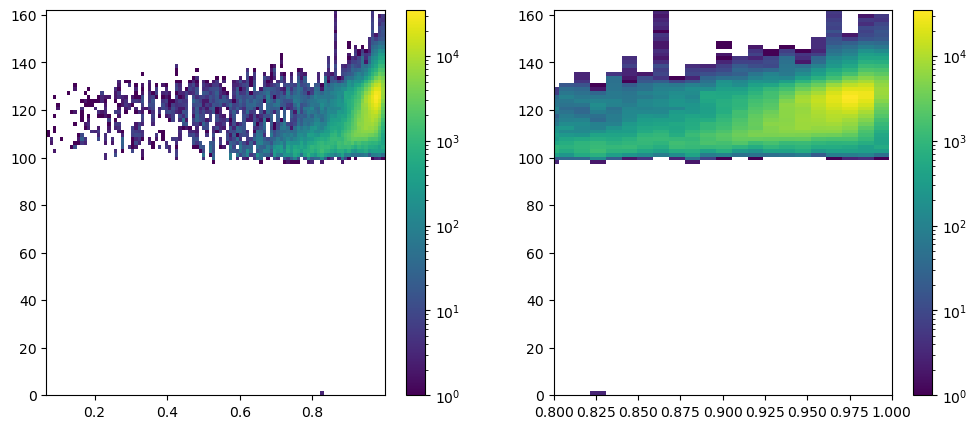

In [13]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(121)
im = ax.hist2d(corr_seg_vol[~np.isnan(corr_seg_vol)].flatten(),
            mn_act_seg_vol[~np.isnan(corr_seg_vol)].flatten(), bins=100, norm=LogNorm())
fig.colorbar(im[3], ax=ax)
ax.set_aspect('auto')

ax = plt.subplot(122)
im = ax.hist2d(corr_seg_vol[~np.isnan(corr_seg_vol)].flatten(),
               mn_act_seg_vol[~np.isnan(corr_seg_vol)].flatten(), bins=100, norm=LogNorm())
ax.set_xlim(0.8, 1)
fig.colorbar(im[3], ax=ax)
ax.set_aspect('auto')

plt.show()

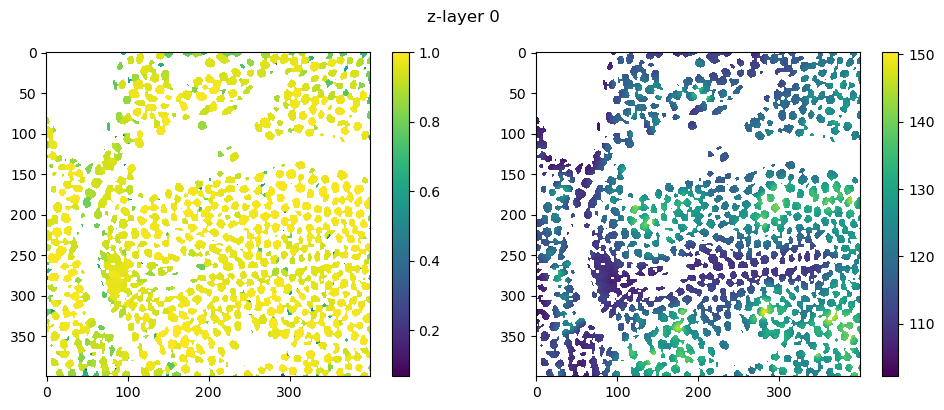

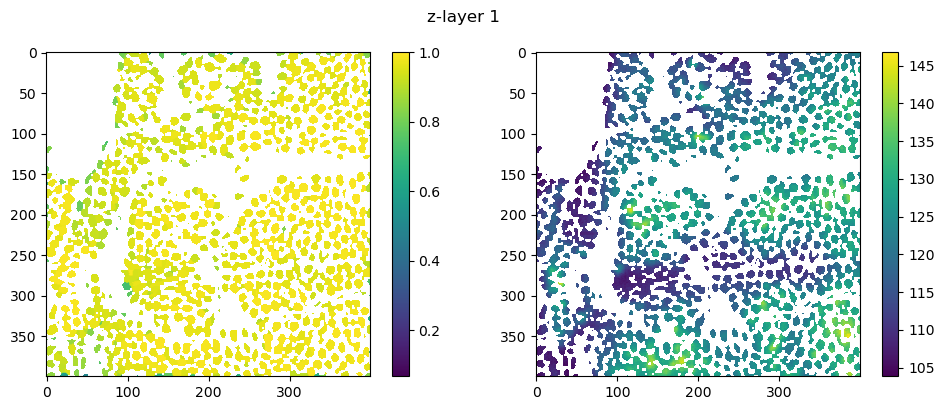

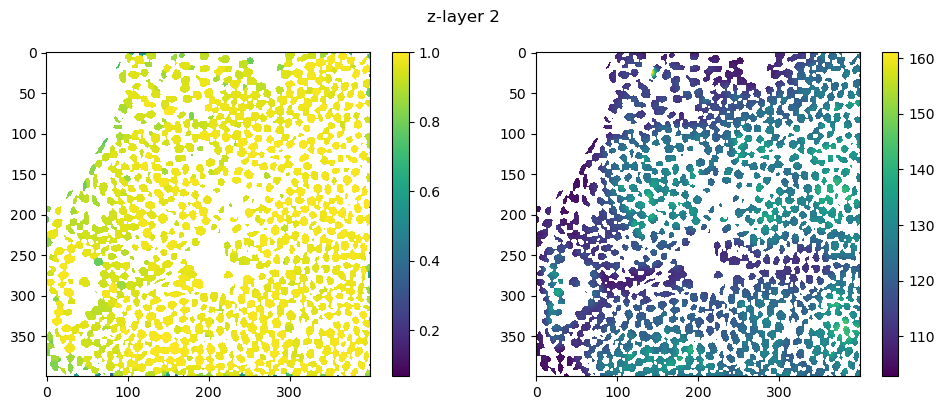

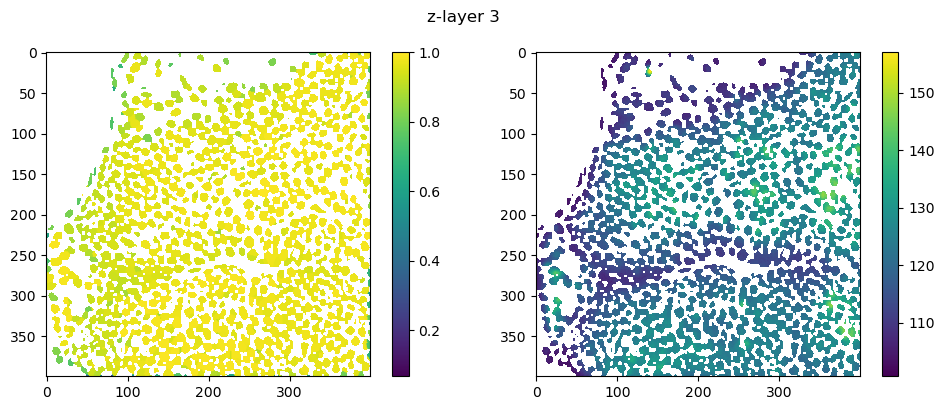

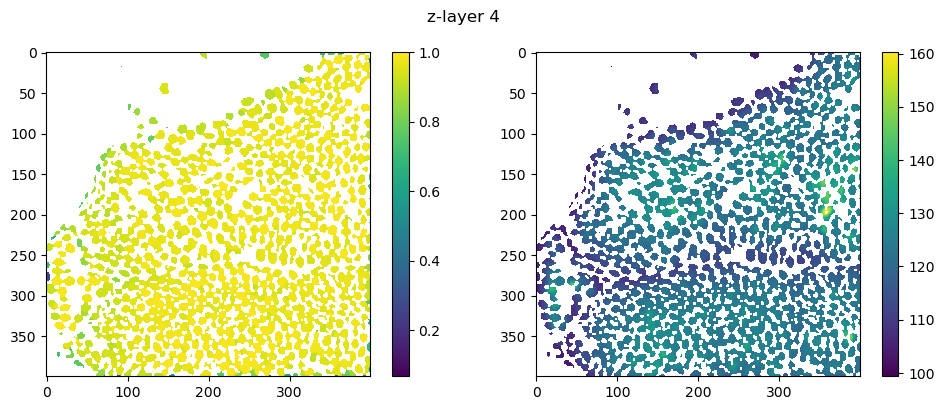

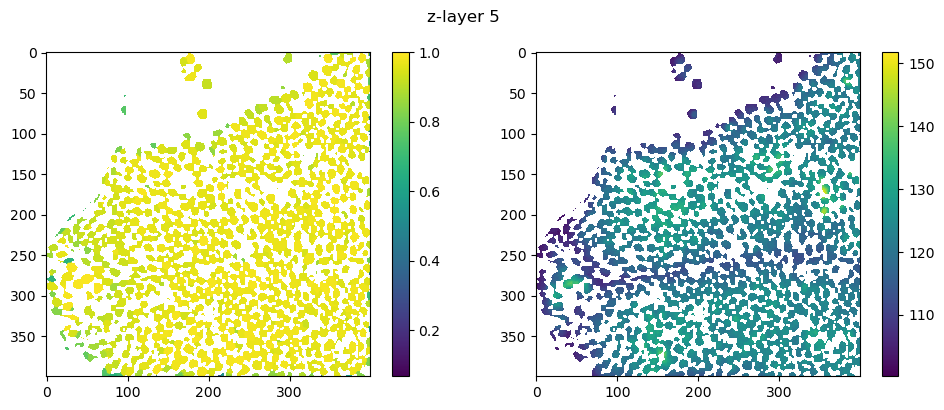

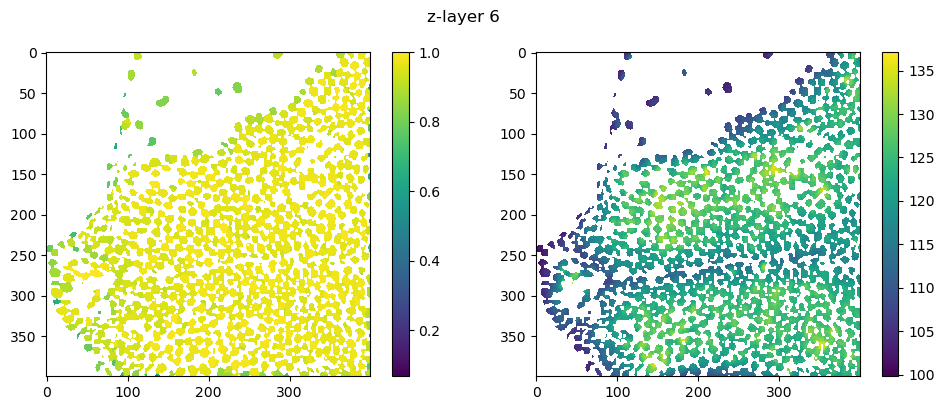

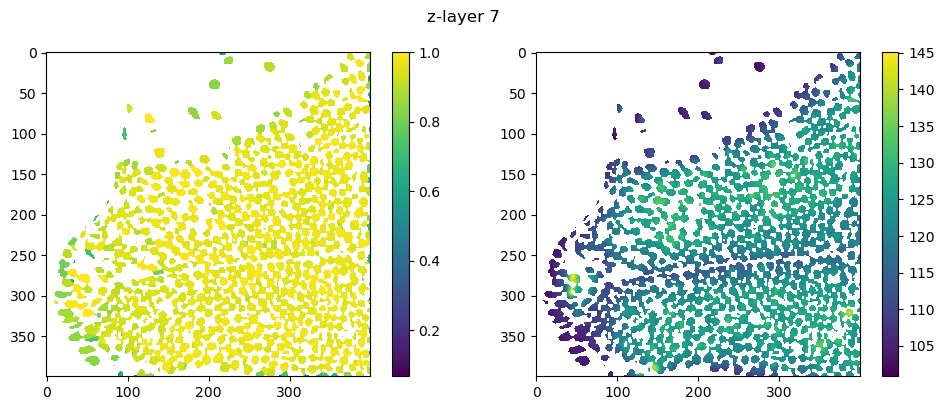

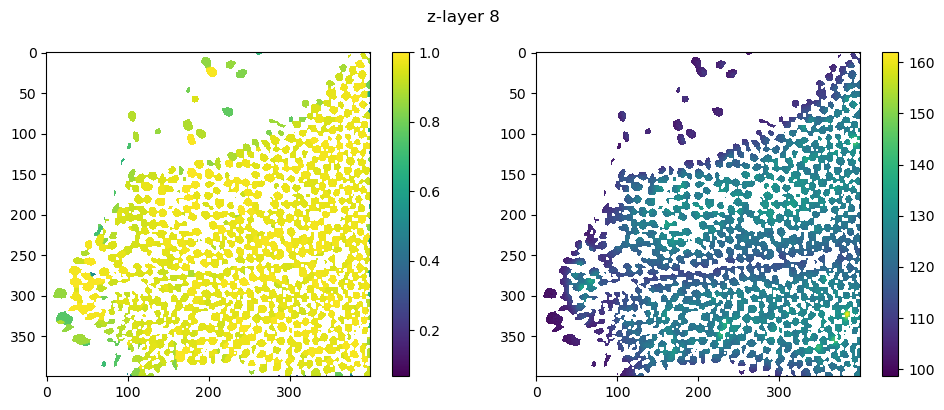

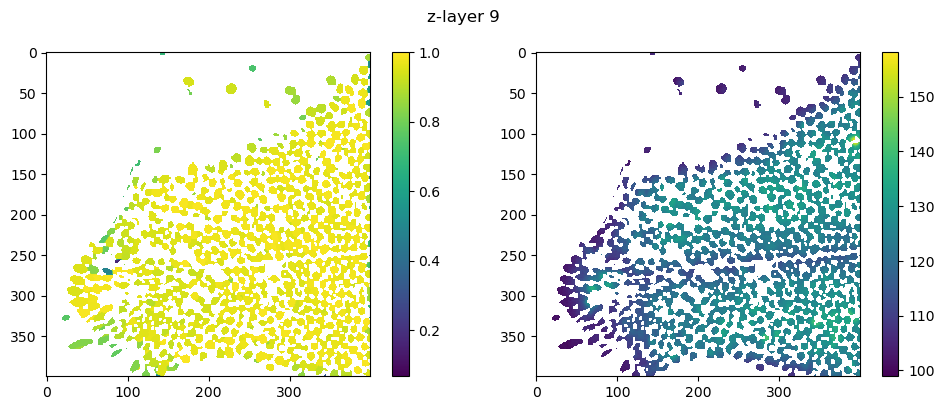

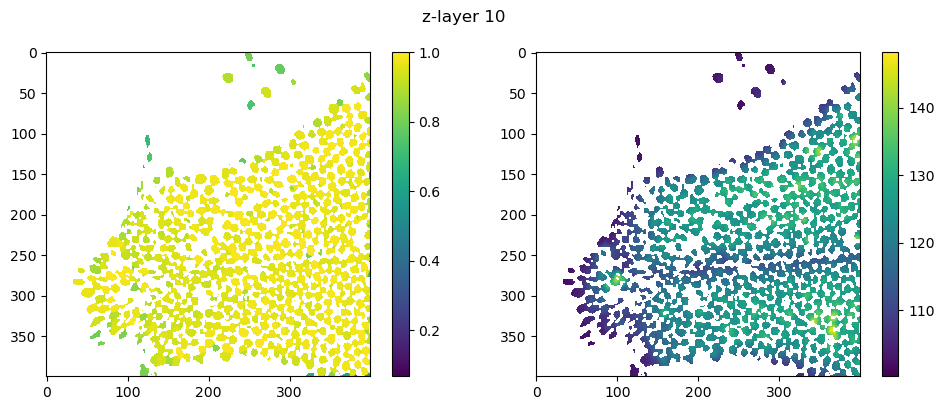

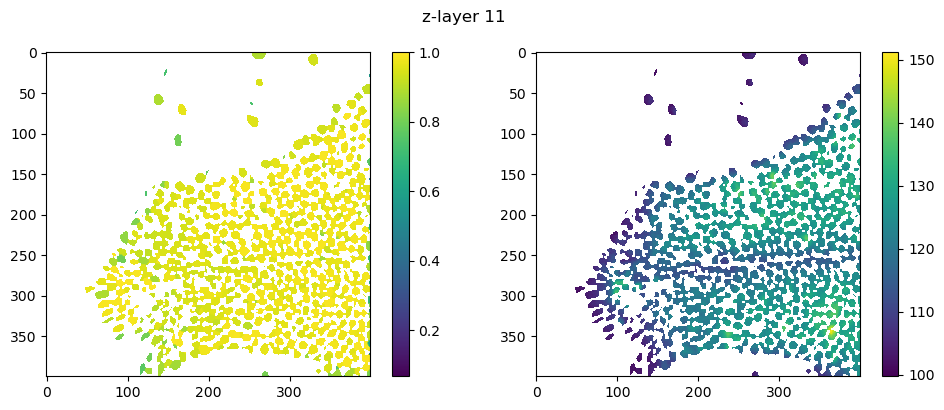

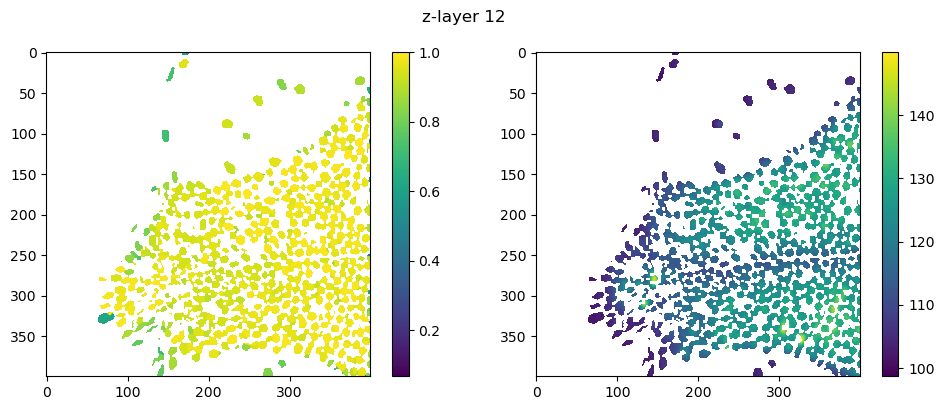

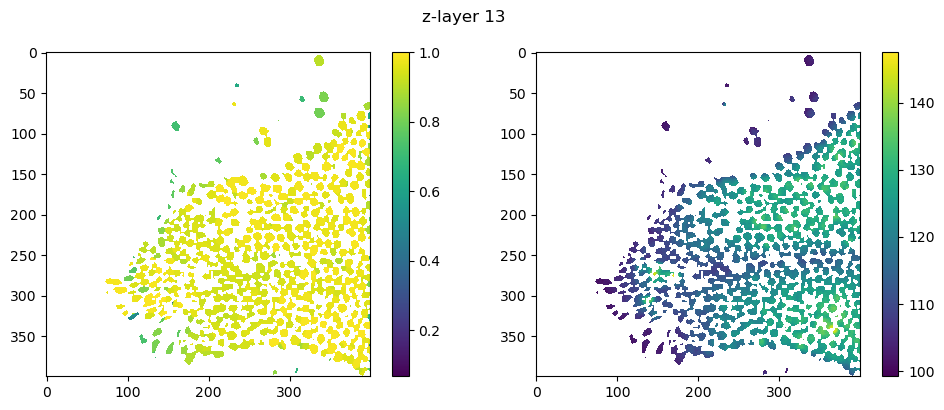

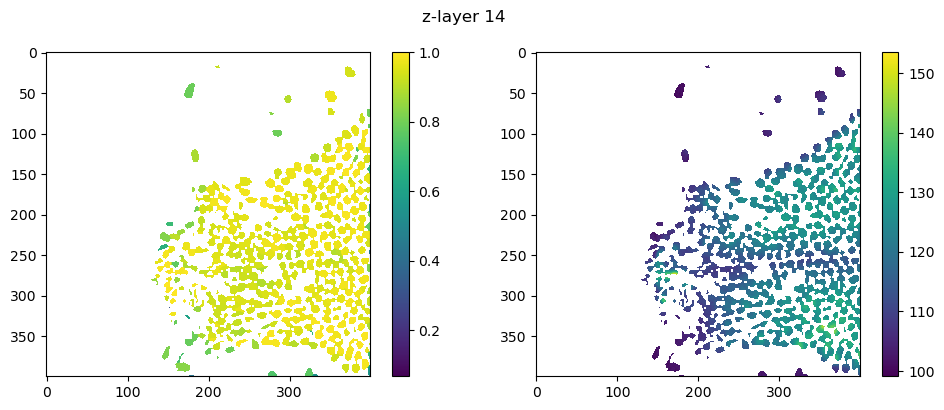

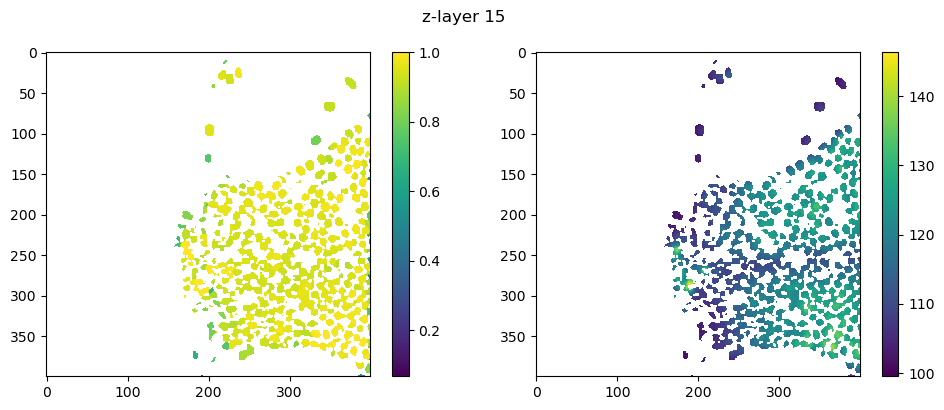

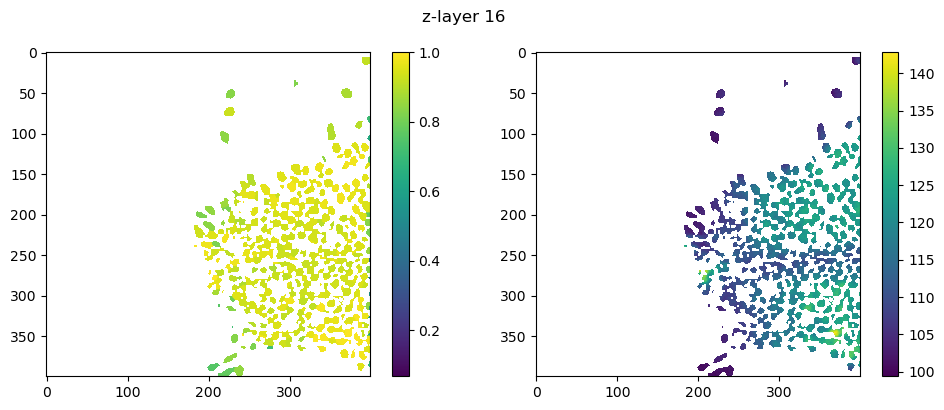

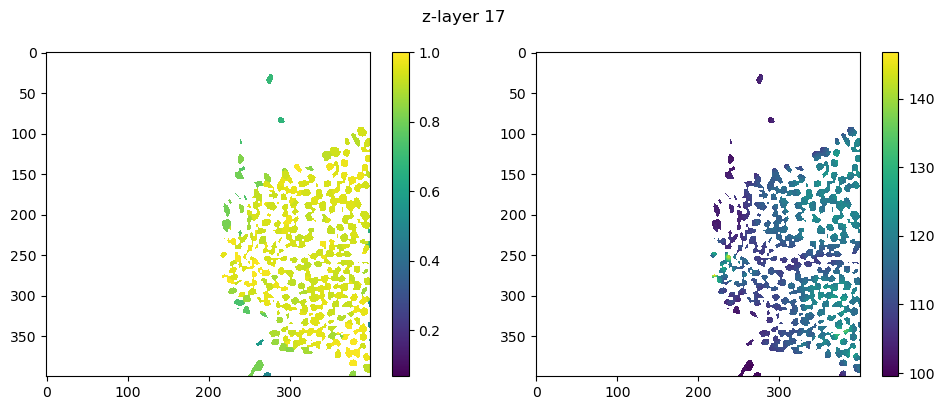

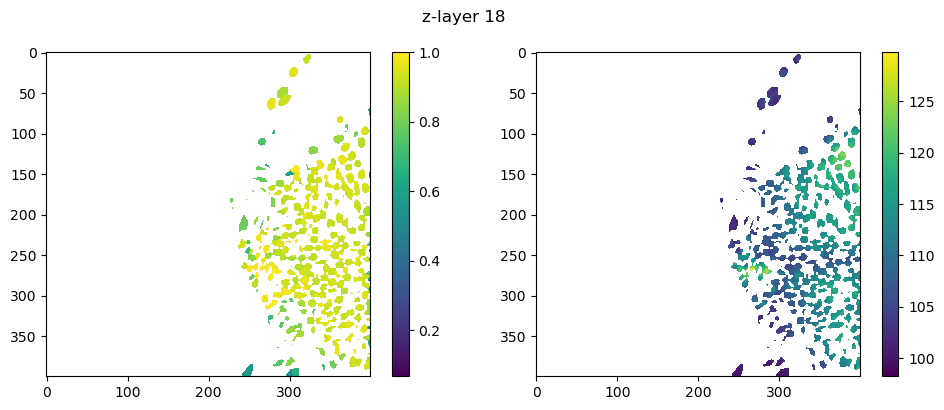

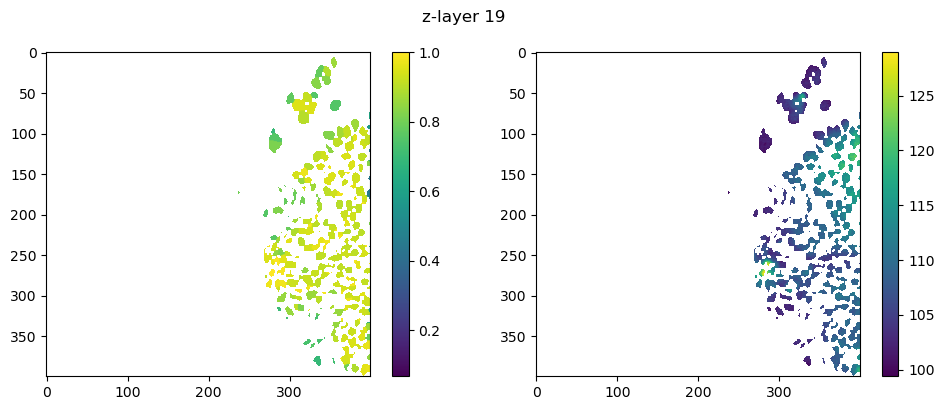

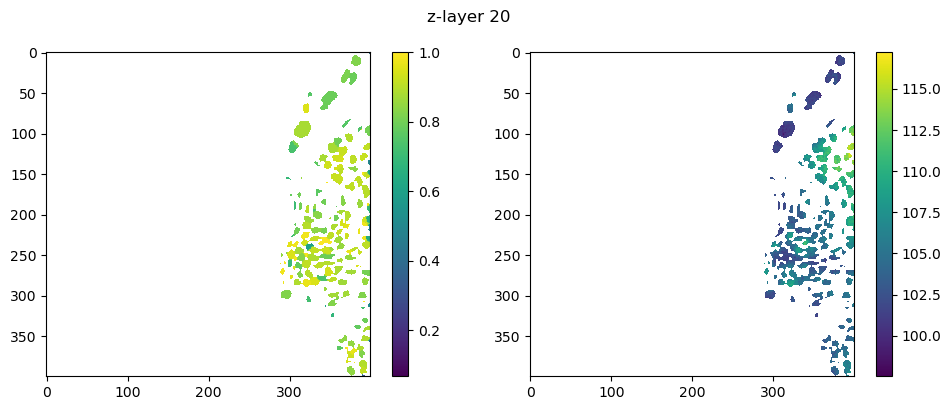

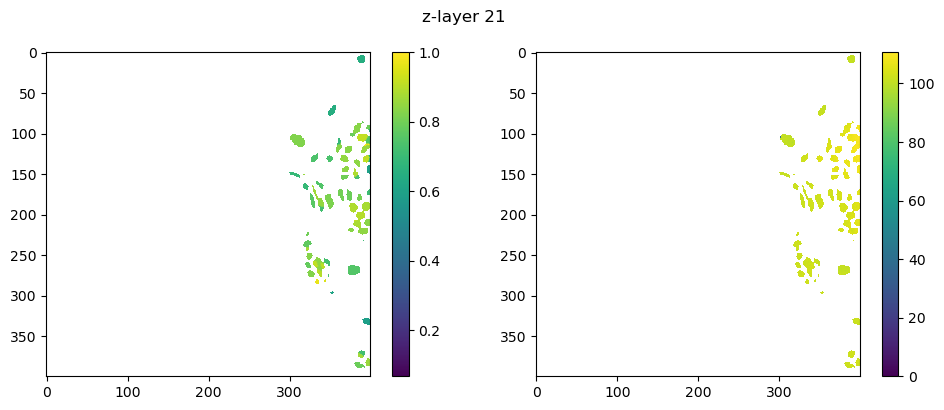

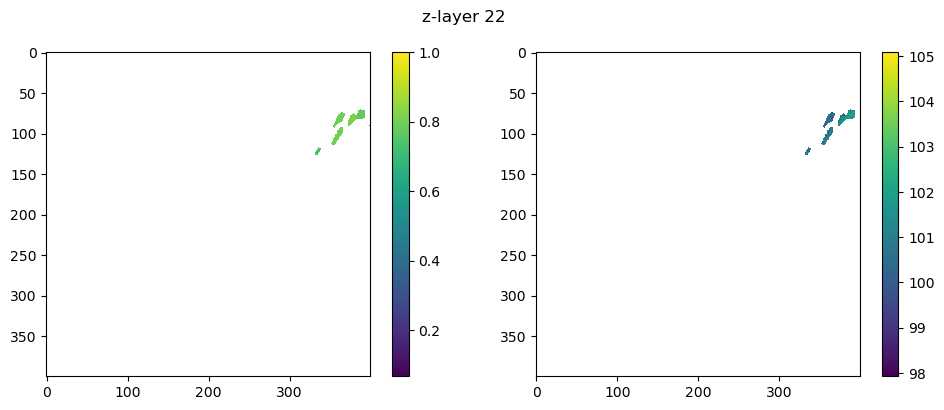

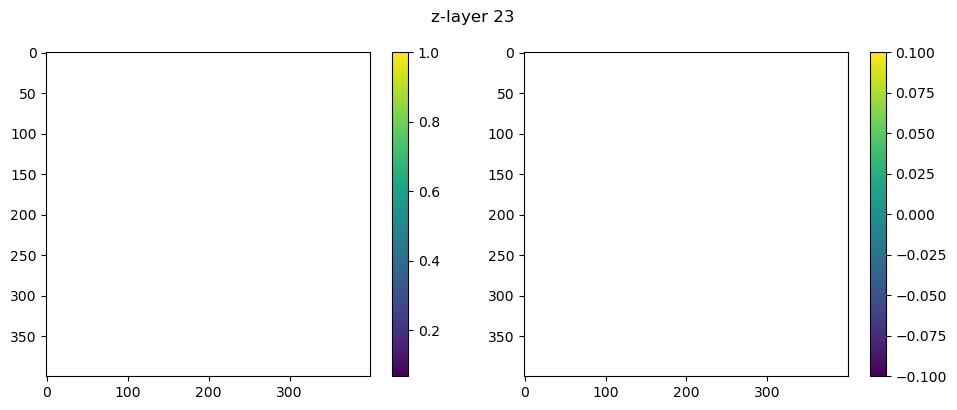

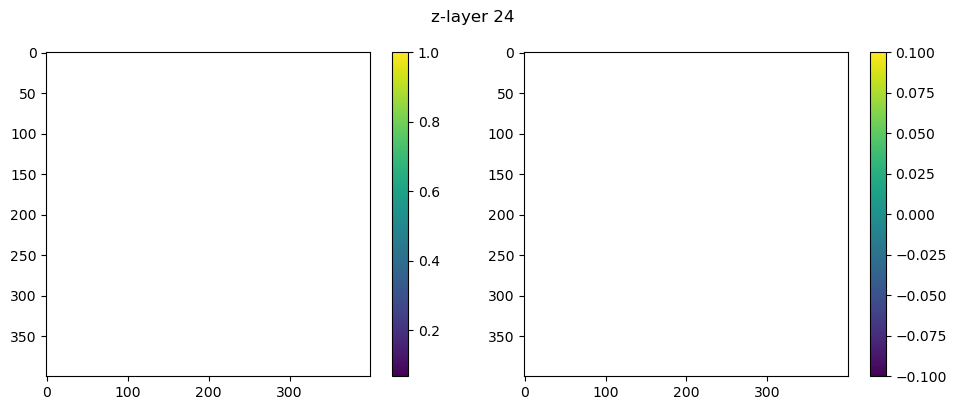

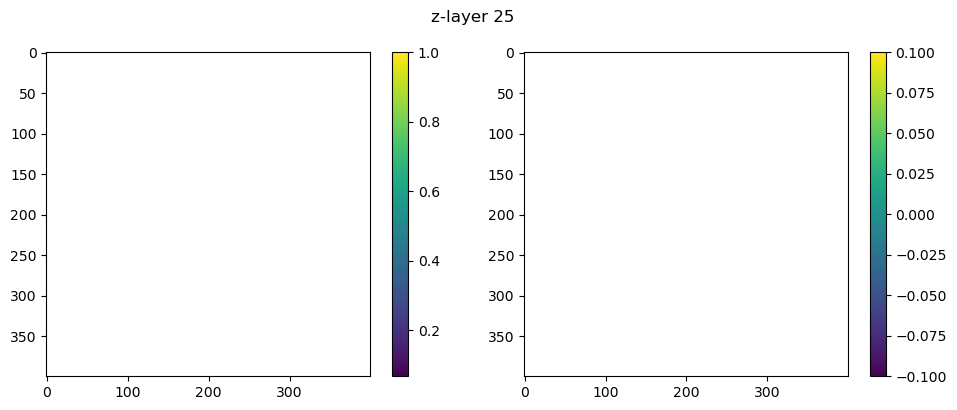

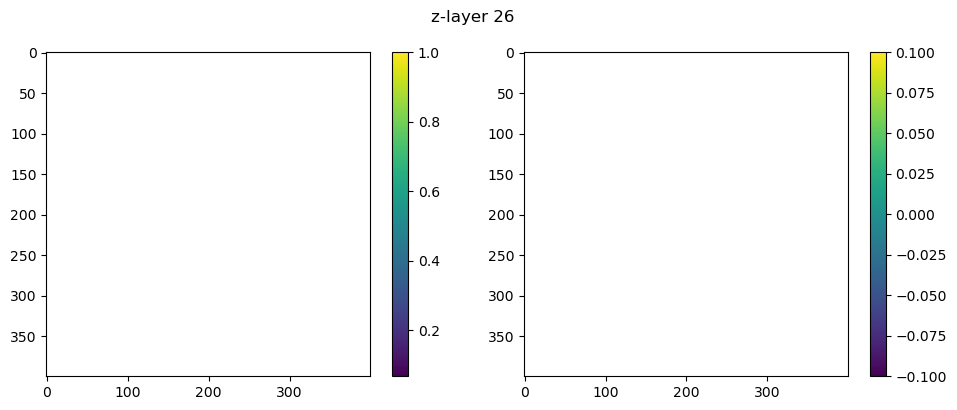

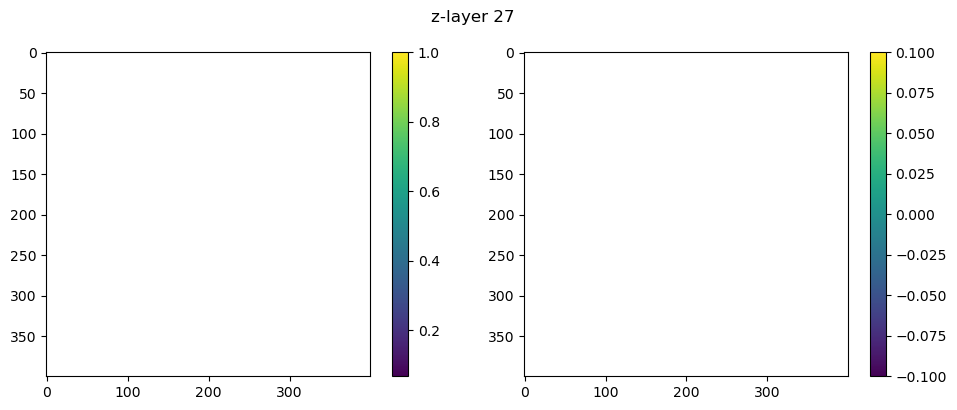

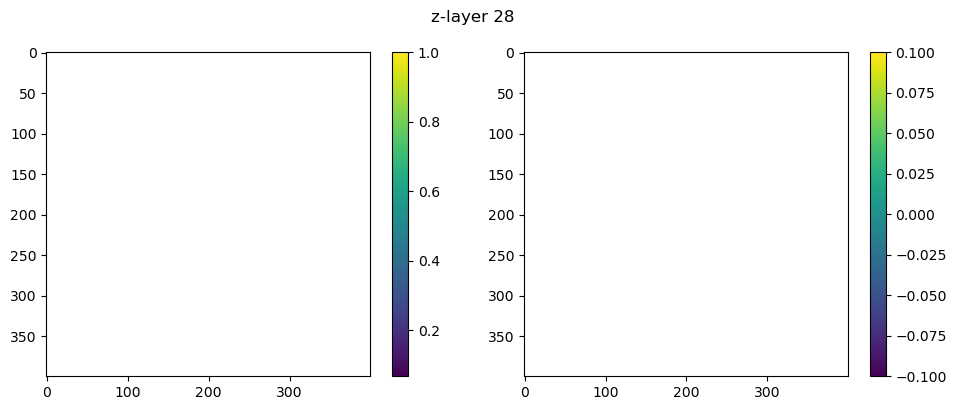

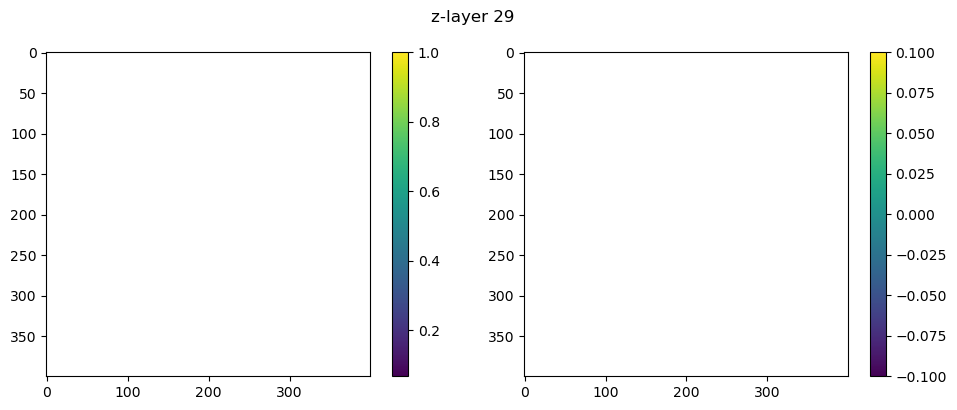

In [14]:
for z in range(corr_seg_vol.shape[0]):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    ax = axes[0]
    im = ax.imshow(corr_seg_vol[z], vmin=np.nanmin(corr_seg_vol), vmax=1)
    fig.colorbar(im, ax=ax)

    
    ax = axes[1]
    im = ax.imshow(mn_act_seg_vol[z])
    fig.colorbar(im, ax=ax)
    
    fig.suptitle('z-layer {}'.format(z))
    
    fig.tight_layout()
    plt.show()

### Threshold by distance

In [15]:
# from tqdm.notebook import tqdm

# # Set up S matrix
# # unique_segments = np.unique(segments)[1:]
# N_cells = len(valid_inds)
# inds = [np.argwhere(segments == u+1) for u in tqdm(valid_inds)]

# np.save('./segment_inds.npy', np.array(inds, dtype=object))
inds = np.load('./segment_inds.npy', allow_pickle=True)

In [16]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

spacing = np.array([7, 1, 1])
N_cells = len(valid_inds)

def calculate_min_distance(coords_mask1, coords_mask2):
   
    # Calculate the Euclidean distances between all pairs of coordinates
    distances = cdist(coords_mask1 * spacing,
                      coords_mask2 * spacing, metric='euclidean')
    
    # Find the minimum distance
    min_distance = np.min(distances) if distances.size > 0 else np.inf
    
    return min_distance

min_distances = np.zeros(shape=(N_cells, N_cells), dtype='float32')
for i in tqdm(range(N_cells)):
    for j in range(N_cells):
        if i > j:
            min_distances[i, j] = calculate_min_distance(inds[i], inds[j])
            min_distances[j, i] = min_distances[i, j]
            

  0%|          | 0/15251 [00:00<?, ?it/s]

IndexError: index 15163 is out of bounds for axis 0 with size 15163

In [ ]:
np.save('./min_distances_sl.npy', min_distances)
# min_distances = np.load('./min_distances_sl.npy')

In [ ]:
sns.heatmap(min_distances)
plt.show()

#### Naive

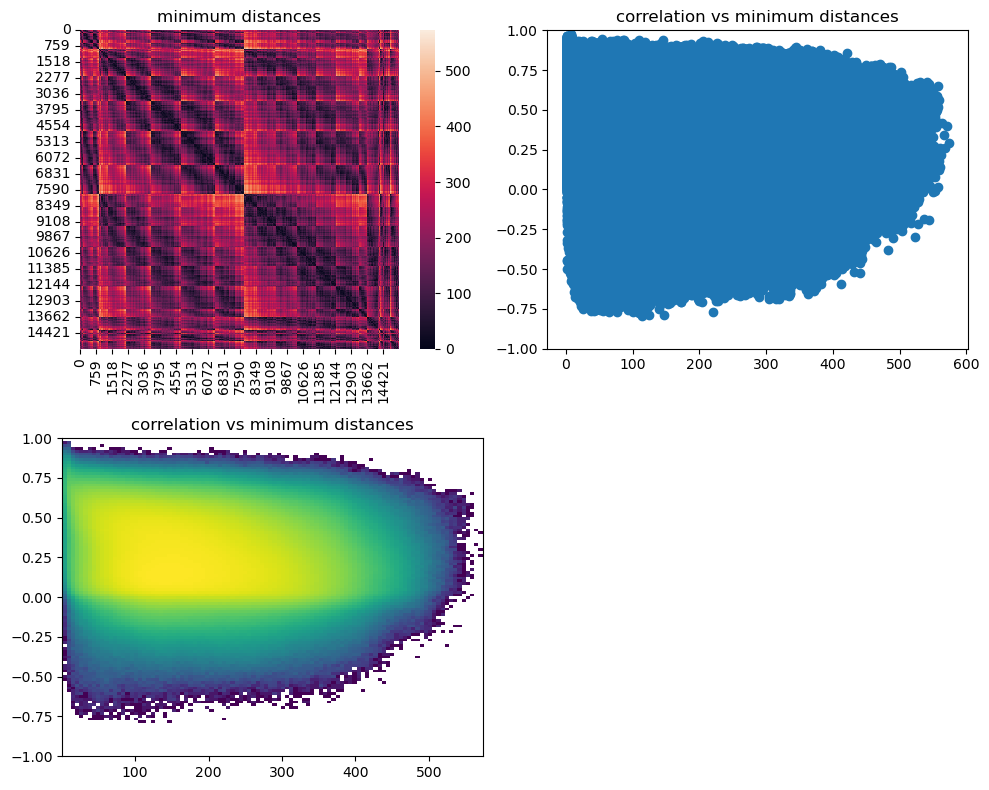

In [65]:
from matplotlib.colors import LogNorm

triu_indices = np.triu_indices(N_neurons, k=1)

fig = plt.figure(figsize=(10, 8))

ax = plt.subplot(221)
sns.heatmap(min_distances, ax=ax)
ax.set_title('minimum distances')
ax.set_aspect('equal')

ax = plt.subplot(222)
ax.scatter(min_distances[triu_indices],
           corrmat_naive[triu_indices])
ax.set_title('correlation vs minimum distances')
ax.set_ylim(-1, 1)

ax = plt.subplot(223)
ax.hist2d(min_distances[triu_indices],
          corrmat_naive[triu_indices],
          norm=LogNorm(),
          bins=100)
ax.set_title('correlation vs minimum distances')
ax.set_ylim(-1, 1)

# ax = plt.subplot(224)
# inds = np.argwhere(min_distances[triu_indices] < np.percentile(min_distances[triu_indices], 50)).squeeze()
# ax.hist2d(min_distances[triu_indices][inds],
#           corrmat_naive[triu_indices][inds],
#           norm=LogNorm(),
#           bins=50)
# ax.set_title('correlation vs minimum distances')
# ax.set_ylim(-1, 1)

fig.tight_layout()
plt.show()

#### NMF

In [ ]:
from matplotlib.colors import LogNorm

triu_indices = np.triu_indices(N_neurons, k=1)

fig = plt.figure(figsize=(10, 8))

ax = plt.subplot(221)
sns.heatmap(min_distances, ax=ax)
ax.set_title('minimum distances')
ax.set_aspect('equal')

ax = plt.subplot(222)
ax.scatter(min_distances[triu_indices],
           corrmat_NMF[triu_indices])
ax.set_title('correlation vs minimum distances')
ax.set_ylim(-1, 1)

ax = plt.subplot(223)
ax.hist2d(min_distances[triu_indices],
          corrmat_NMF[triu_indices],
          norm=LogNorm(),
          bins=100)
ax.set_title('correlation vs minimum distances')
ax.set_ylim(-1, 1)

# ax = plt.subplot(224)
# inds = np.argwhere(min_distances[triu_indices] < np.percentile(min_distances[triu_indices], 50)).squeeze()
# ax.hist2d(min_distances[triu_indices][inds],
#           corrmat_NMF[triu_indices][inds],
#           norm=LogNorm(),
#           bins=50)
# ax.set_title('correlation vs minimum distances')
# ax.set_ylim(-1, 1)

fig.tight_layout()
plt.show()

#### NMF vs naive

In [ ]:
dist_thr = 5
dist_mask = min_distances < dist_thr

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
ax.imshow(dist_mask)
ax.set_title('distance mask')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 12))

ax = plt.subplot(221)
corrmat_naive = np.corrcoef(ts_naive)
corrmat_naive[~dist_mask] = 0
im = ax.imshow(corrmat_naive, vmin=0, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('correlation H_naive', fontsize=20)

ax = plt.subplot(222)
corrmat_NMF = np.corrcoef(ts_NMF)
corrmat_NMF[~dist_mask] = 0
im = ax.imshow(corrmat_NMF, vmin=0, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('correlation H_NMF', fontsize=20)

ax = plt.subplot(223)
diff_corrmat = corrmat_NMF - corrmat_naive
diff_corrmat[~dist_mask] = np.nan
im = ax.imshow(diff_corrmat, vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
ax.set_title('diff correlation H_NMF & H_naive', fontsize=20)

ax = plt.subplot(224)
triu_indices = np.triu_indices(diff_corrmat.shape[0], k=1)
ax.hist(diff_corrmat[triu_indices], bins=50, color='k')
ax.axvline(np.nanmean(diff_corrmat), color='r')
ax.axvline(0, color='b', linestyle=':')
ax.set_title('avg {}'.format(np.nanmean(diff_corrmat)))

plt.show()

# Just comparing time traces

151443


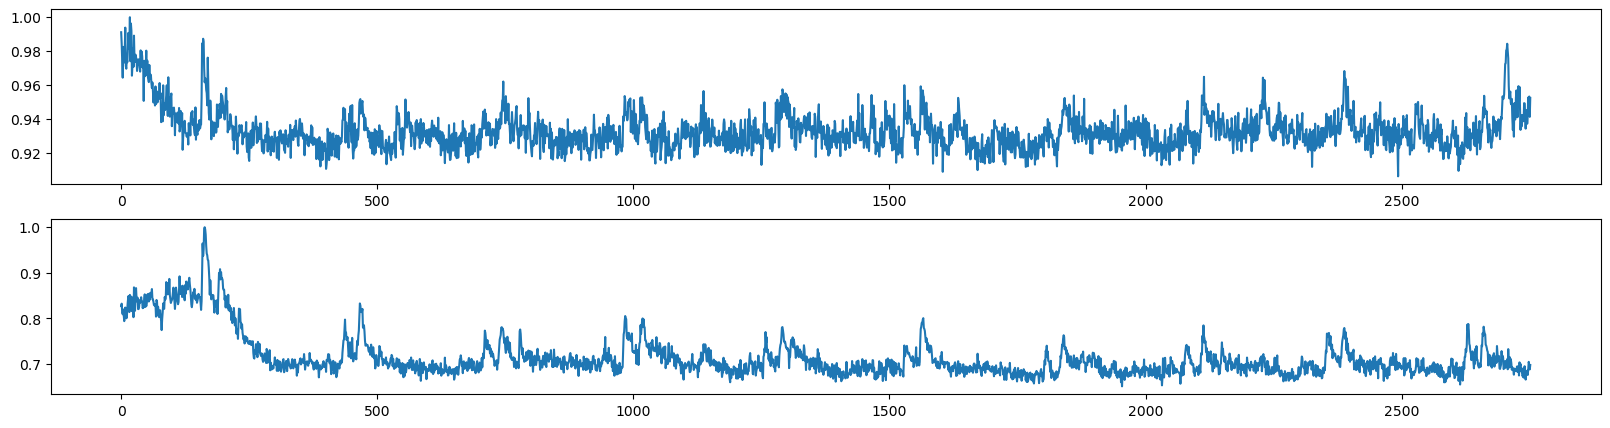

In [150]:
i = 35

ind = valid_inds_NMF[i]
print(ind)

fig, axes = plt.subplots(2, 1, figsize=(20, 5))

ax = axes[0]
ax.plot(ts_naive[151443, :])

ax = axes[1]
plt.plot(ts_NMF[ind, :])
plt.show()

In [85]:
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

i = 35
ind = valid_inds_NMF[i]

corrs = [pearsonr(ts_NMF[ind, :], t).statistic for t in tqdm(ts_naive[valid_inds_naive])]

  0%|          | 0/152492 [00:00<?, ?it/s]

In [86]:
np.nanmax(corrs)

0.9818772483624146

In [87]:
ind

151443

In [88]:
valid_inds_naive[np.where(corrs == np.nanmax(corrs))]

array([150183])

In [106]:
inds = np.where(segments == 151443)

In [110]:
np.min(inds, 1)

array([ 15, 246, 280])

In [111]:
np.max(inds, 1)

array([ 15, 259, 290])

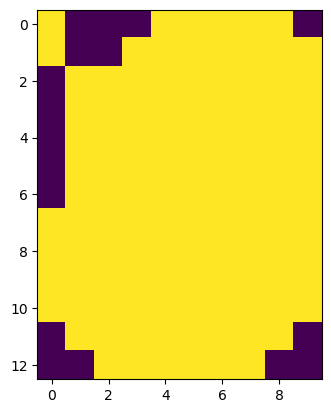

In [112]:
plt.imshow(segments[15, 246:259, 280:290])

In [4]:
# Load raw data
segments_path = '/groups/bishop/bishoplab/Luuk/segmentNMF/notebooks/NMF_development/masks.zarr'
segments = zarr.open(segments_path)[:]

ts_directory = '/nrs/ahrensraverfish/fleishmang/F50/function/EMLmultiFISH_f50_6dpf_10ms_51z_2Hz_23min_VisRap_20220615_112144'
ts_path = ts_directory + '/motion_corrected.zarr'
ts = zarr.open(ts_path, mode='r+')

In [5]:
segments.shape

(51, 1248, 2048)

In [6]:
ts.shape

(2752, 51, 1248, 2048)

In [7]:
inds = np.where(segments == 150183)

In [8]:
inds

(array([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36]),
 array([483, 483, 483, 483, 484, 484, 484, 484, 484, 484, 484, 485, 485,
        485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486,
        486, 486, 486, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488,
        488, 488, 488, 488, 488, 489, 489, 489, 489, 489, 490, 490, 490,
        490, 491, 491, 491, 491, 492, 492, 493, 484, 484, 484, 484, 485,
        485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 487,
        487, 487, 487, 487, 487, 488, 488, 488, 488, 488, 488, 489, 489,
        489, 489, 490, 490]),
 array([789, 790, 791, 792, 7

In [9]:
zmin, xmin, ymin = np.min(inds, 1)
zmax, xmax, ymax = np.max(inds, 1)

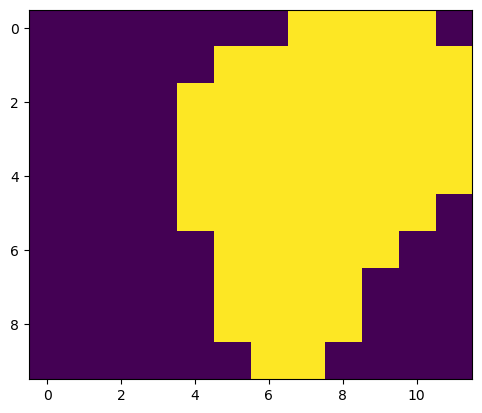

In [10]:
plt.imshow(segments[zmin, xmin:xmax, ymin:ymax] == 150183)

In [221]:
ts = zarr.open(ts_path, mode='r+')[:, zmin:zmax+1, xmin:xmax, ymin:ymax]

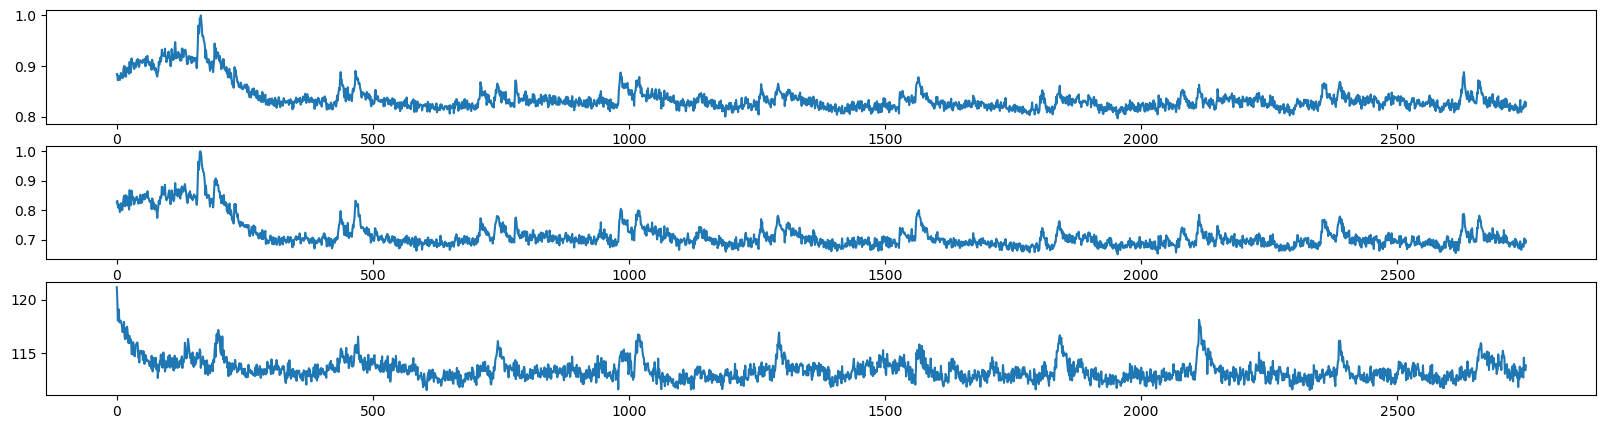

In [223]:
fig, axes = plt.subplots(3, 1, figsize=(20, 5))

ax = axes[0]
ax.plot(ts_naive[150183, :])

ax = axes[1]
ax.plot(ts_NMF[ind, :])

ax = axes[2]
ax.plot(np.mean(ts, axis=(1, 2, 3)))

plt.show()

In [5]:
# Load raw data
segments_path = '/groups/bishop/bishoplab/Luuk/segmentNMF/notebooks/NMF_development/masks_sl_small.zarr'
timeseries_path = '/groups/bishop/bishoplab/Luuk/segmentNMF/notebooks/NMF_development/ts_data_sl_small.zarr'

segments = zarr.load(segments_path)
ts = zarr.load(timeseries_path)

In [6]:
from CircuitSeeker.function import apply_cell_mask
from CircuitSeeker.function import distributed_apply_cell_mask

ts_new = apply_cell_mask(segments, ts)

cluster_kwargs_mean = {
    'project':'ahrens',
    'ncpus':2,
    'threads':1,
    'min_workers':1,
    'max_workers':12,
}

# taken from EASI-FISH R0 segmentation directly
ncells = 203396

ts_new_dist = distributed_apply_cell_mask(segments, ts, batch_size=100, cluster_kwargs=cluster_kwargs_mean)

IBM Spectrum LSF 10.1.0.0 build 601088, Apr 15 2022
Copyright International Business Machines Corp. 1992, 2016.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

  binary type: linux3.10-glibc2.17-x86_64
/groups/ahrens/home/hesselinkl/anaconda3/envs/multifish_squared/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Cluster dashboard link:  http://10.36.215.40:8787/status
Cluster adapting between 1 and 12 workers with 2 cores per worker
*** This cluster has an upper bound cost of 1.68 dollars per hour ***


/groups/ahrens/home/hesselinkl/anaconda3/envs/multifish_squared/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/groups/ahrens/home/hesselinkl/anaconda3/envs/multifish_squared/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.wa

In [7]:
ts_new

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [100.9234 , 100.72766, 100.57021, ..., 100.46383, 100.59574,
        100.51915]], dtype=float32)

In [8]:
ts_new_dist

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [100.9234 , 100.72766, 100.57021, ..., 100.46383, 100.59574,
        100.51915]], dtype=float32)

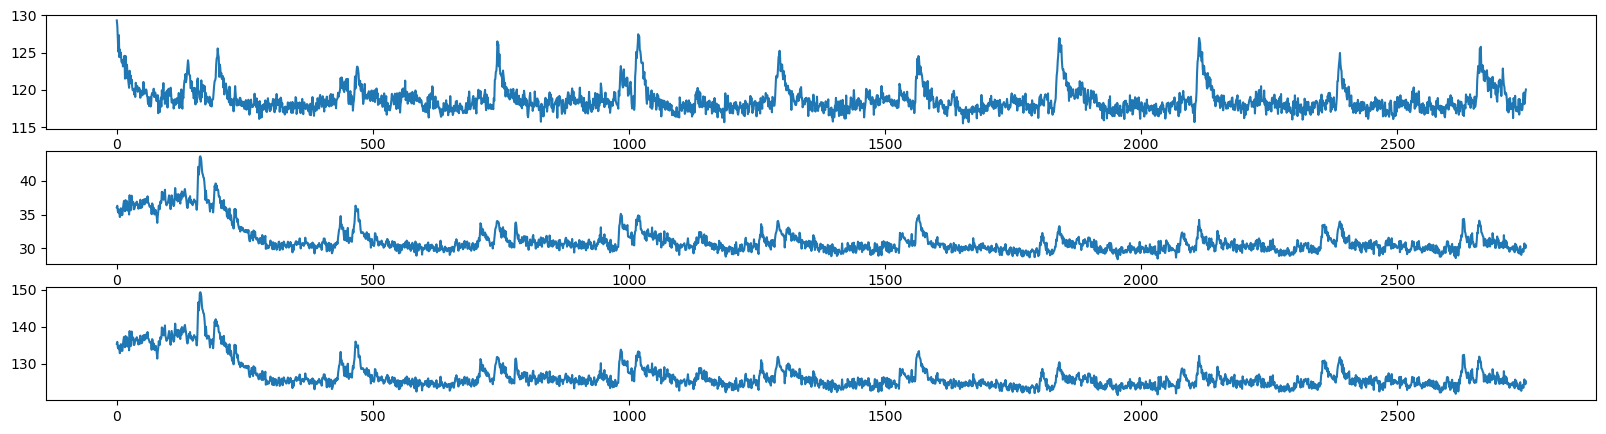

In [9]:
ind = 151443

fig, axes = plt.subplots(3, 1, figsize=(20, 5))

ax = axes[0]
ax.plot(ts_naive[ind-1, :])

ax = axes[1]
ax.plot(ts_NMF[ind, :])

ax = axes[2]
ax.plot(ts_new[ind-1, :])

plt.show()